To enable interactive plots, run `jupyter labextension install jupyter-matplotlib` followed by:

In [1]:
!pip install --upgrade ipympl matplotlib -q
%matplotlib ipympl

In [2]:
!pip install hdbscan -q
!pip install pymatgen -q

In [3]:
import hdbscan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import manifold
from ipywidgets import interact, Output
from IPython.display import clear_output

import sys
sys.path.append('..')
sys.path.append('../autoencoder')
# sys.path.append('/notebooks/Beta-VAE/')
from models import*

from src.band_plotters import*
from src.Tiff32Image import*
from src.TensorImageNoised import *
from src.cluster_plotters import *
sys.path.append('/notebooks/band-fingerprint/autoencoder/resnet_autoencoder')
sys.path.append('/notebooks/band-fingerprint/src')

from model import *

from ae_misc import *

In [4]:
FINGERPRINT_LENGTH = 98

#FINGERPRINT_NAME = "functional_10dpi_bernoulli_VAE_L={0}".format(FINGERPRINT_LENGTH)
FINGERPRINT_NAME = "224_2channel_resnet_L={0}".format(FINGERPRINT_LENGTH)
# FINGERPRINT_NAME = "all_k_branches_histogram_-8_to_8".format(FINGERPRINT_LENGTH)
# FINGERPRINT_NAME = "128x128_random_erase_resnet18_VAE_L={0}".format(FINGERPRINT_LENGTH)

PERPLEXITY = 30
FLAT_ONLY = True
BORING_COLUMNS = ["flat_segments", "flatness_score", "binary_flatness", "horz_flat_seg", "exfoliation_eg", "A", "B", "C", "D", "E", "F"]
INPUT_NAME = f"{FINGERPRINT_NAME}_perplexity_{PERPLEXITY}_length_{FINGERPRINT_LENGTH}.csv"

## Load Data

In [5]:
df = pd.read_csv(f"../fingerprints/{INPUT_NAME}", index_col="ID")
if FLAT_ONLY:
    df = df[df.horz_flat_seg>0]
df.head()

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,90,91,92,93,94,95,96,97,fx,fy
ID,,,,,,,,,,,,,,,,,,,,,
2dm-3,TlS,AB,2,4,4,0.84646,bottom-up,1,3,0.095794,...,2.325100,1.733577,1.816098,1.953408,1.904952,1.718350,1.920829,1.940830,-17.031164,-22.583645
2dm-21,TaI3,AB3,162,3,3,0.88201,bottom-up,1,1,0.097255,...,2.226489,2.289640,2.589102,2.477097,2.594307,2.217409,2.636327,2.281451,-85.320190,19.231680
2dm-22,Li2O,AB2,164,3,3,0.96678,bottom-up,1,4,0.037593,...,2.502424,1.772349,1.775590,1.941162,1.745729,1.716548,1.714002,1.817789,74.049220,-91.258260
2dm-25,VBr4,AB4,123,3,3,0.97834,bottom-up,1,2,0.140290,...,2.372130,2.224227,2.399812,2.197275,2.769758,2.584419,2.809708,2.114330,36.688946,55.726463
2dm-29,SBr,AB,2,4,4,0.82037,bottom-up,1,3,0.067035,...,2.852715,2.168420,2.470804,2.357963,2.278249,2.280239,2.296243,2.235125,11.995536,-106.832634


## Cluster

In [6]:
fingerprint_cols = [str(i) for i in range(FINGERPRINT_LENGTH)]
BORING_COLUMNS += fingerprint_cols

In [12]:
clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                        gen_min_span_tree=True, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=4, min_samples=3, p=0.2)

clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=0.8, approx_min_span_tree=True,\
gen_min_span_tree=False, leaf_size=40, metric='minkowski', cluster_selection_method='leaf', min_cluster_size=6, min_samples=2, p=0.2)

clusterer.fit(df[fingerprint_cols])


df["labels"] = clusterer.labels_
df["member_strength"] = clusterer.probabilities_


# View cluster for bernoulli auto-encoded fingerprint


In [7]:
# old static model
# # change path to the location of the desired trained model
# model_path = "../autoencoder/trained_models/nearest_12_v1_length_{0}.pkl".format(FINGERPRINT_LENGTH)
# # name of the energy{name} folder which holds the input band tensors
# CNN_input_file_index = "_12_nearest_bands"
# # load the model that we have already trained on the data
# trained_model = load_learner(model_path)


bernoulli_input_file_index="no_dos_bw_2/dpi_10"
    
bernoulli_model = BetaVAE_B(z_dim=64, nc=3)

checkpoint = torch.load("/notebooks/Beta-VAE/checkpoints/BW_B_gamma100_z64/last")
bernoulli_model.load_state_dict(checkpoint['model_states']['net'])

bernoulli_model.eval()


def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])
    print(num_plots)
    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        #ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        
        ax[i].set_xlabel(index)
        
    for i, index in enumerate(df[df.labels==label].index):
        #plot(index)
        # old static model
        #view_prediction(index, trained_model.model, -17, 20, width=128)
        # VAE model
        view_prediction_images(index, bernoulli_model, image_directory="../../../storage/2dmatpedia/images/{0}".format(bernoulli_input_file_index), width=64, height=64, height_mode="pad", act_func=F.sigmoid)

#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

NameError: name 'BetaVAE_B' is not defined

In [ ]:
# old static model
# # change path to the location of the desired trained model
# model_path = "../autoencoder/trained_models/nearest_12_v1_length_{0}.pkl".format(FINGERPRINT_LENGTH)
# # name of the energy{name} folder which holds the input band tensors
# CNN_input_file_index = "_12_nearest_bands"
# # load the model that we have already trained on the data
# trained_model = load_learner(model_path)


VAE_input_file_index="energies4"
    
VAE_model = BetaVAE_B(z_dim=32)

checkpoint = torch.load("/notebooks/Beta-VAE/checkpoints/energies4_B_beta10_z32/last")
VAE_model.load_state_dict(checkpoint['model_states']['net'])

VAE_model.eval()


def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        #ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        
        ax[i].set_xlabel(index)
        
    for i, index in enumerate(df[df.labels==label].index):
        #plot(index)
        # old static model
        #view_prediction(index, trained_model.model, -17, 20, width=128)
        # VAE model
        view_prediction(index, VAE_model, -7, 7, image_directory="energies4", width=64, height=64, height_mode="pad", act_func=F.sigmoid)


#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))
interact(view_cluster, label=(111))

# View cluster for any fingerprint

In [13]:
%matplotlib inline
def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(100))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        plt.plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        # # plot version with some print from cluster 0 subtracted, to better visualise the fingerprint differences
        # ax[i].plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols]-np.array(df[df.labels==1][fingerprint_cols])[0])
        plt.xlabel(index)
        plt.title("fingerprint")
        plt.show()
        #plot(index)

interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

interactive(children=(IntSlider(value=23, description='label', max=47, min=-1), Output()), _dom_classes=('widg…

<function __main__.view_cluster(label)>

# VIEW cluster for resnet AE or VAE (must change model import below, and the .predict function in view_cluster!)

In [22]:
pip install mpimg

  Preparing metadata (setup.py) ... done
  Created wheel for mpimg: filename=mpimg-0.0.1-py3-none-any.whl size=1328 sha256=45008a28539b4455e465642a894d841f7761b964abed89a03ccfaabd13539820
  Stored in directory: /root/.cache/pip/wheels/e3/29/51/8e9a0f15f2b8e885d912e8ce4cda2fb4646f6692c7b14d98a1
Successfully built mpimg
Note: you may need to restart the kernel to use updated packages.


In [6]:
class Binarize(Transform):
    def __init__(self, threshold=0.8):self.threshold=threshold
    def encodes(self, o): 
        # print(o)
        mask = (o > (255 * self.threshold))
        return mask * 255

In [7]:
def bce_loss(pred, targ):
    x_recon, mu, logvar = pred
    
    return nn.BCEWithLogitsLoss()(x_recon, targ) + 0.05 * kld_mean_loss(mu, logvar)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


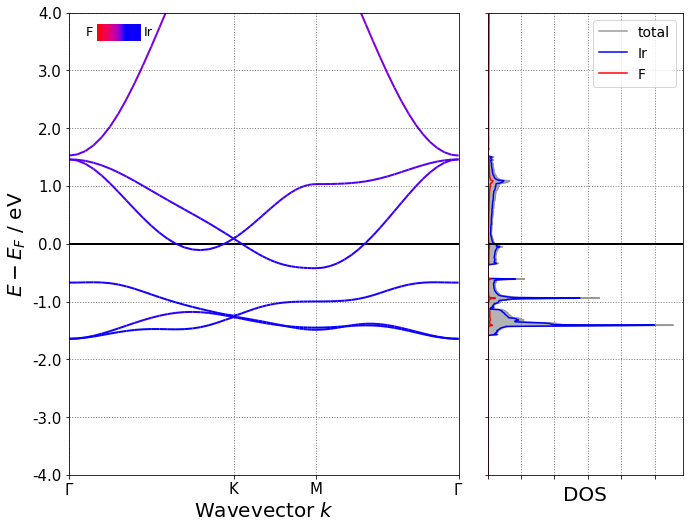

In [8]:
plot("2dm-1")

In [25]:
# MUST CHANGE FOR DIFFERENT LATENT LENGTH MODEL!
learn = load_learner("../autoencoder/trained_models/resnet18_size224_lossbce_channels2.pkl")

#model_path = "../autoencoder/trained_models/vae_resnet18_size128_lossbcekl_randerase_channels4.pkl"
#learn = load_learner(model_path)

def view_cluster(label):
    display(df[df.labels==label].drop(BORING_COLUMNS, axis=1).head(200))

    num_plots = len(df[df.labels==label])

    #fig, ax = plt.subplots(num_plots, 1, figsize=(4, 1*num_plots))

    for i, index in enumerate(df[df.labels==label].index):
        plt.plot(np.linspace(0, FINGERPRINT_LENGTH, FINGERPRINT_LENGTH), df.loc[index][fingerprint_cols])
        plt.xlabel(index)
        plt.title("fingerprint")
        plt.show()
        
        # full 2d matpedia plot:
        #plot(index)
        #plt.show()
        print(df.loc[index]["member_strength"])
        # just plot the input bands:
        input_bands = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        input_bands.show()
        
        # FOR NORMAL AE
        out = learn.predict(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        show_image(torch.sigmoid(out[1]))
        
        # FOR VAE
        #x_recon, mu, sigma = predict(learn,DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{index}.png")
        #show_image(torch.sigmoid(x_recon[0]))
        #x_recon.size()
        
        plt.show()
        
#interact(view_cluster, label=(-1, len(np.unique(df.labels))-2, 1))

interact(view_cluster, label=45)

interactive(children=(IntSlider(value=45, description='label', max=135, min=-45), Output()), _dom_classes=('wi…

<function __main__.view_cluster(label)>

In [12]:
df[df.formula=="SmF3"].head()

#df.index

,formula,gen_formula,space_group,segments,flat_segments,flatness_score,discovery,binary_flatness,horz_flat_seg,exfoliation_eg,...,54,55,56,57,58,59,fx,fy,labels,member_strength
ID,,,,,,,,,,,,,,,,,,,,,
2dm-875,SmF3,AB3,59,4,4,0.85193,bottom-up,1,3,0.20317,...,0.0,0.0,0.0,0.0,0.0,71.0,39.441105,-80.09885,46,1.0


## Rerun TSNE (ONLY IF ON FLAT SUBSET)

In [9]:
if FLAT_ONLY:
    tsne = manifold.TSNE(n_components=2, early_exaggeration=12.0, init="pca",learning_rate="auto", random_state=0, perplexity=10,n_iter=10000, verbose=2, metric="minkowski")
    fingerprint_2d = tsne.fit_transform(df[fingerprint_cols])
    df.fx, df.fy = fingerprint_2d[:, 0], fingerprint_2d[:, 1]

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2005 samples in 0.001s...
[t-SNE] Computed neighbors for 2005 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2005
[t-SNE] Computed conditional probabilities for sample 2000 / 2005
[t-SNE] Computed conditional probabilities for sample 2005 / 2005
[t-SNE] Mean sigma: 1.019422
[t-SNE] Computed conditional probabilities in 0.019s


/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 74.6053772, gradient norm = 0.0123159 (50 iterations in 1.259s)
[t-SNE] Iteration 100: error = 75.4825821, gradient norm = 0.0099334 (50 iterations in 1.130s)
[t-SNE] Iteration 150: error = 76.0996323, gradient norm = 0.0045396 (50 iterations in 1.281s)
[t-SNE] Iteration 200: error = 76.4148102, gradient norm = 0.0026537 (50 iterations in 1.280s)
[t-SNE] Iteration 250: error = 76.4638977, gradient norm = 0.0028607 (50 iterations in 1.142s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.463898
[t-SNE] Iteration 300: error = 2.3112350, gradient norm = 0.0024505 (50 iterations in 1.212s)
[t-SNE] Iteration 350: error = 1.8639212, gradient norm = 0.0010709 (50 iterations in 1.185s)
[t-SNE] Iteration 400: error = 1.6555761, gradient norm = 0.0006331 (50 iterations in 1.266s)
[t-SNE] Iteration 450: error = 1.5371760, gradient norm = 0.0004404 (50 iterations in 1.133s)
[t-SNE] Iteration 500: error = 1.4631188, gradient norm = 0.0003249 (50 

/tmp/ipykernel_1666/1740458782.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('turbo')


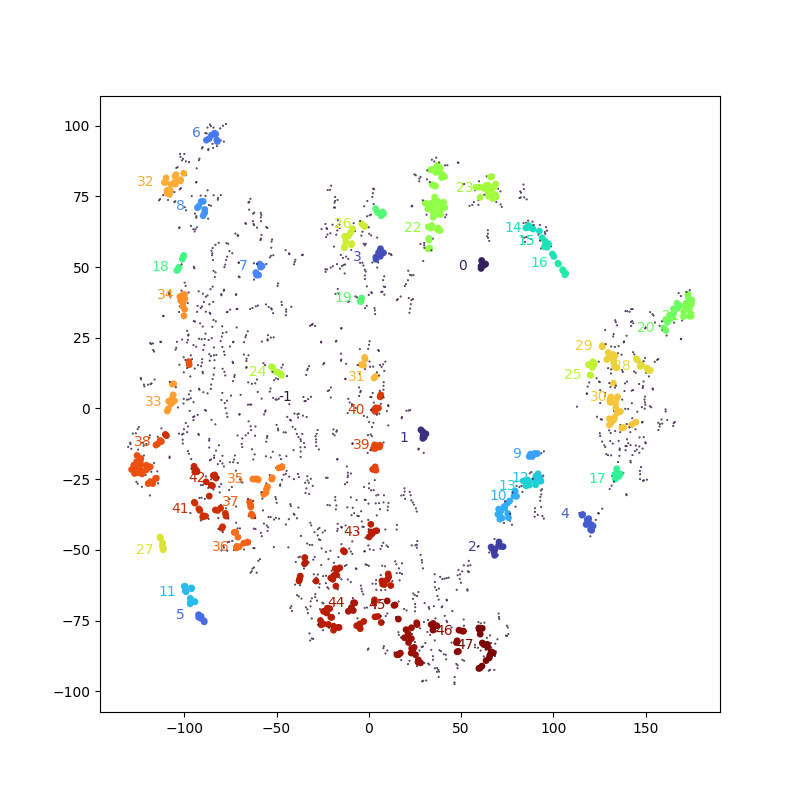

In [28]:
%matplotlib ipympl
labels = clusterer.labels_

fig = plt.figure(figsize=(8,8))
size=np.ones((len(labels),1))*15
size[labels==-1]=0.2
 
unique_label,cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))
    
for rep_id in cluster_rep_index:
        col=cmap(norm(labels[rep_id]))
        plt.annotate(labels[rep_id],fingerprint_2d[rep_id,:]+[-10,0],color=col,alpha=1, weight='normal', ha='center', va='center', size=10).draggable()

plt.scatter(fingerprint_2d[:,0], fingerprint_2d[:,1],s=size, c=labels*5, cmap="turbo")


plt.show()



In [30]:
plt.savefig("resnet_2_channel_L=96_tsne.png", dpi=200, bbox_inches="tight")


## Plots

# Output table of all clusters with exemplar mat formulae

In [32]:
from pandas.plotting import table

In [33]:
sorted_cluster_df = df[df.labels!=-1].sort_values(by=['labels','member_strength'], ascending=[True, False])

In [34]:
len(sorted_cluster_df)

347

In [35]:
N_clusters = len(np.unique(clusterer.labels_))-1
print(N_clusters)

49


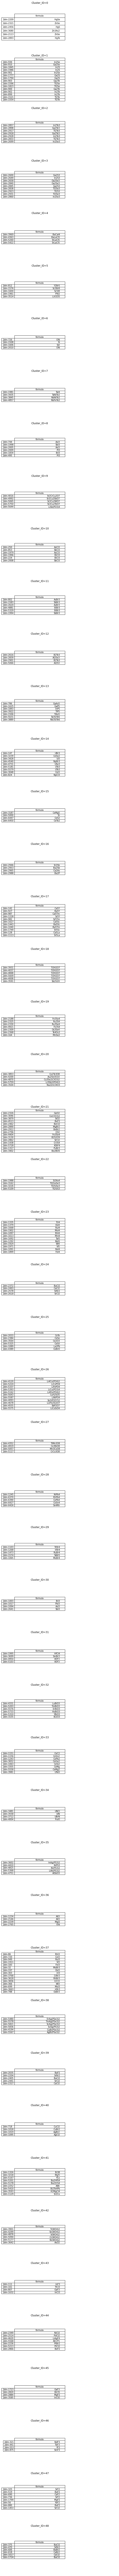

In [37]:

#N_clusters = 3
num_bands = 3
fig, axs = plt.subplots(N_clusters, 2, figsize=(8,3.5*N_clusters))

# for i in range(1,num_bands+1):
#     axs[0, i].set_title('exemplar_{0}'.format(i))

for i in range(0, N_clusters):
    #print(i)
    df_part1 = sorted_cluster_df[sorted_cluster_df.labels==i]["formula"]
    # min table size of 15
    if(len(df_part1)>=15):
        df_part1 = df_part1.head(15)
    
    axs[i, 0].set_title('Cluster_ID={0}'.format(i), y=0.95)
    axs[i, 0].axis("off")
    axs[i, 1].axis("off")

    #print(df.loc[index]["member_strength"])
    # just plot the input bands:
#     input_bands_1 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[0]}.png")
#     input_bands_2 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[1]}.png")
#     input_bands_3 = Image.open(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/{df_part1.index[2]}.png")

#     axs[i,1].imshow(input_bands_1, extent=[-4, 4, -4, 4], aspect=1)
#     axs[i,2].imshow(input_bands_2, extent=[-4, 4, -4, 4], aspect=1)
#     axs[i,3].imshow(input_bands_3, extent=[-4, 4, -4, 4], aspect=1)
    
    table(axs[i,0], df_part1, loc="center")  # where df is your data frame
    fig.tight_layout()
#plt.subplots_adjust(wspace=0.2)   
plt.savefig("OLD_PRINT_MCS_4_MS_3_clusters_big_table")
plt.show()

<Figure size 432x288 with 0 Axes>

# HIERARCHY dendogram

In [38]:
pip install ete3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.7 MB/s eta 0:00:0000:01:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273785 sha256=b8a67c2db1fec423ed54040546b76cb5bfd46d16eaf1b1866d0493d967936f95
  Stored in directory: /root/.cache/pip/wheels/ad/2e/cc/edcca721b423e1604c84f480a1e8e0547a223bfc068d373259
Successfully built ete3
Note: you may need to restart the kernel to use updated packages.


In [62]:
pip install PyQt5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.7/335.7 kB 38.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [63]:
from ete3 import Tree, TreeStyle
min_spanning_tree = clusterer.minimum_spanning_tree_.to_networkx()


In [64]:
ete3.__file__

NameError: name 'ete3' is not defined

In [ ]:
# Create a new ETE Tree instance
ete_tree = Tree()

# Create a dictionary to store ETE nodes for quick access
ete_nodes = {}

# Add nodes to the ETE Tree
for node in min_spanning_tree.nodes():
    ete_node = ete_tree.add_child(name=str(node))
    ete_nodes[node] = ete_node

# Add edges to the ETE Tree
for edge in min_spanning_tree.edges():
    node1, node2 = edge
    ete_node1 = ete_nodes[node1]
    ete_node2 = ete_nodes[node2]
    ete_node1.add_child(ete_node2)

# Render the tree
ete_tree.render("tree.png")

In [1]:
min_spanning_tree = clusterer.minimum_spanning_tree_.to_networkx()

ete_tree = Tree()

# Create a dictionary to store ETE nodes for quick access
ete_nodes = {}

# Add nodes to the ETE Tree
for node in min_spanning_tree.nodes():
    ete_node = ete_tree.add_child(name=str(node))
    ete_nodes[node] = ete_node

# Add edges to the ETE Tree
for edge in min_spanning_tree.edges():
    node1, node2 = edge
    ete_node1 = ete_nodes[node1]
    ete_node2 = ete_nodes[node2]
    ete_node1.add_child(ete_node2)

# Render the tree
ts = TreeStyle()
ts.mode = "c"  # Circular layout
ts.show_leaf_name = True
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180

#ete_tree.render("tree.png", tree_style=ts)




NameError: name 'clusterer' is not defined

# UMAP

In [20]:
pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 59.1 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 29.4 MB/s eta 0:00:0000:0100:01
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86839 sha256=8ec437bdfc416736a4bd97b4130f730a424ed1d6b0edf40cdcc3c195c6636a52
  Stored in directory: /root/.cache/pip/wheels/0f/01/17/26951217a11fb724b7027c6dd5b620b6d368104f7e6d4171fc
Successfully built umap-learn
Note: you may need to restart the kernel to use updated packages.


In [49]:
import umap

ModuleNotFoundError: No module named 'umap'

In [92]:
# Create a UMAP model
umap_model = umap.UMAP(n_components=2, random_state=42, metric="minkowski", min_dist=0.0, n_neighbors=20)

# Fit and transform the data
fingerprint_umap = umap_model.fit_transform(df[fingerprint_cols])

# Assign the UMAP coordinates to the DataFrame
df['umap_x'], df['umap_y'] = fingerprint_umap[:, 0], fingerprint_umap[:, 1]

/usr/local/lib/python3.9/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [30]:
# Scatter plot with different colors for each cluster
plt.figure(figsize=(10, 8))
for cluster in df['cluster_label'].unique():
    cluster_data = df[df['cluster_label'] == cluster]
    plt.scatter(cluster_data['umap_x'], cluster_data['umap_y'], label=f'Cluster {cluster}')

    
    
    
plt.title('UMAP Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

KeyError: 'cluster_label'

<Figure size 720x576 with 0 Axes>

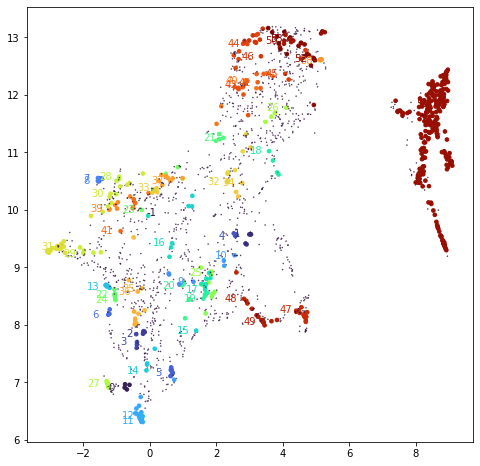

In [120]:
labels = clusterer.labels_


fig = plt.figure(figsize=(8, 8))
size = np.ones((len(labels), 1)) * 13
size[labels == -1] = 0.2

unique_label, cluster_rep_index, counts = np.unique(labels, return_index=True, return_counts=True)
cmap = plt.cm.get_cmap('turbo')
norm = matplotlib.colors.Normalize(vmin=min(labels), vmax=max(labels))

#df[df['umap_x'].to_numpy()<=0] = df[df['umap_x'].to_numpy()<=0]*-2
#df[df['umap_y'].to_numpy()<=0] = df[df['umap_y'].to_numpy()<=0]*-1
plt.scatter(df['umap_x'], df['umap_y'], s=size, c=labels * 5, cmap="turbo")

# Assuming fingerprint_2d is replaced by UMAP coordinates 'umap_x' and 'umap_y'
for rep_id in cluster_rep_index:
    col = cmap(norm(labels[rep_id]))
    plt.annotate(labels[rep_id], df[['umap_x', 'umap_y']].values[rep_id, :] + [-0.4, -0.0],
                 color=col, alpha=1, weight='normal', ha='center', va='center', size=10).draggable()

plt.show()


In [40]:
pip install colorcet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 30.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Output()

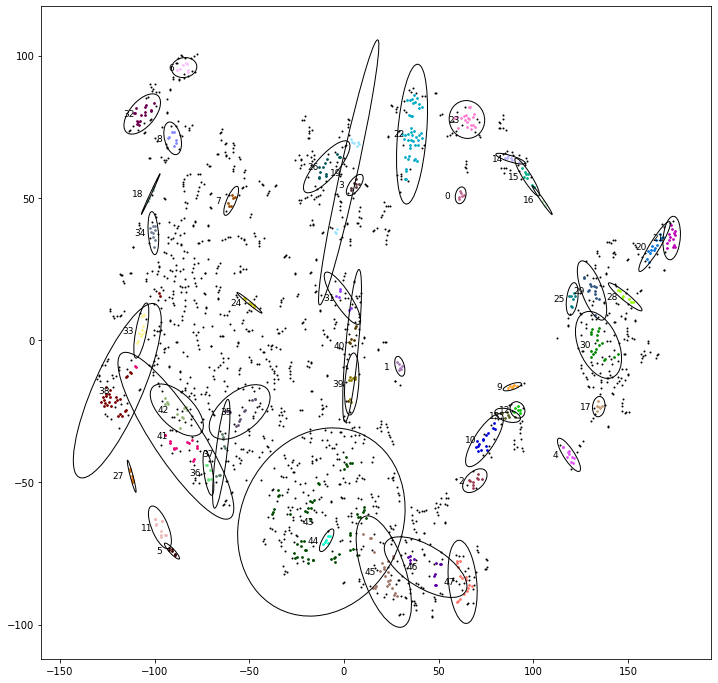

In [41]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(12, 12))
ax = plot_groups(df,"labels", ax=ax)
ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

Output()

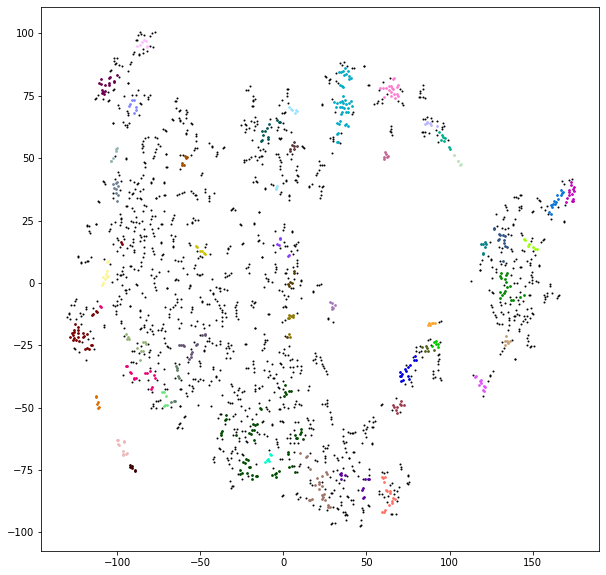

In [42]:
out = Output()

@out.capture()
def onclick(event):
    clear_output()
    closest = np.sqrt((event.xdata-df.fx)**2 + (event.ydata-df.fy)**2).idxmin()
    label = df.labels.loc[closest]
    print(f"Clicked on material {closest} in cluster {label}")
    display(df[df.labels == label].drop(BORING_COLUMNS, axis=1))
display(out)

fig, ax = plt.subplots(figsize=(10, 10))
ax = plot_groups(df,"labels", ax=ax)
#ax = plot_cluster_ellipses(df, ax=ax, color="black")
# ax.legend()

fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

# 2D HISTOGRAM FOR HDBSCAN PARAMETER OPTIMISATION

In [39]:
MS_vals = np.arange(2,12,1)
MCS_vals = np.arange(2,12,1)

DBCV_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_cluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))
N_uncluster_vals = np.zeros((len(MS_vals),len(MCS_vals)))

for i,MS in enumerate(MS_vals):
    for j,MCS in enumerate(MCS_vals):
        #print(MS,MCS)
        #print(i,j)
        clusterer = hdbscan.HDBSCAN(algorithm='best', alpha=1.0, approx_min_span_tree=True,\
                                gen_min_span_tree=True, leaf_size=40, metric='manhattan', cluster_selection_method='leaf', min_cluster_size=MCS, min_samples=MS, p=0.2)
        #clusterer.fit(30*np.tanh(df[fingerprint_cols])/30)
        clusterer.fit(df[fingerprint_cols])

        df["labels"] = clusterer.labels_
        
        DBCV_vals[-(j+1),i] = clusterer.relative_validity_ 
        N_cluster_vals[-(j+1),i] = len(np.unique(clusterer.labels_))-1
        N_uncluster_vals[-(j+1),i] = len(df[df["labels"]==-1])

        

Text(0.5, 1.0, '[[0.07408321 0.05719583 0.02683594 0.02088851 0.0214418  0.01430383\n  0.01363748 0.01201069 0.00675515 0.00635515]\n [0.0721241  0.05719583 0.03163518 0.02551871 0.0214418  0.02067047\n  0.01363748 0.01201069 0.00675515 0.00635515]\n [0.07654506 0.06111259 0.03566593 0.02551871 0.0312092  0.02067047\n  0.01911904 0.01201069 0.01064017 0.00635515]\n [0.07786822 0.06488722 0.03944247 0.03656153 0.03492427 0.02422886\n  0.01911904 0.01201069 0.01064017 0.00635515]\n [0.09179331 0.07460552 0.04893343 0.03985142 0.03820086 0.03080423\n  0.01911904 0.01781102 0.01064017 0.00635515]\n [0.0778927  0.09393872 0.0545307  0.03516922 0.04101874 0.0363882\n  0.03163183 0.0206466  0.01636958 0.01439212]\n [0.08311159 0.06688069 0.05916007 0.04210127 0.04101874 0.0363882\n  0.03395227 0.02295781 0.02162625 0.01697509]\n [0.07766967 0.07191693 0.05731166 0.04578998 0.04101874 0.0363882\n  0.03395227 0.0266888  0.02162625 0.0206336 ]\n [0.13138373 0.075194   0.06322128 0.0468562  0.046

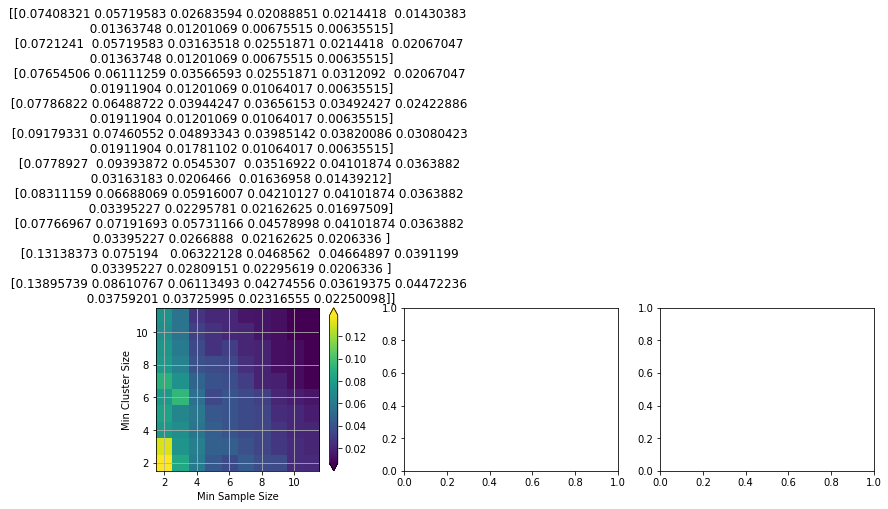

In [55]:
parameter_mesh = np.meshgrid(MS_vals, MCS_vals)
#plt.contourf(MS_vals,MCS_vals,DBCV_vals,5)
#plt.show()
#plt.imshow(DBCV_vals, extent=[2,12,2,12])
names = [DBCV_vals, N_cluster_vals, N_uncluster_vals]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)

D = ax1.imshow(name, extent=[1.5,11.5,1.5,11.5])
fig.colorbar(D, ax=ax1, extend='both')

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")

ax1.grid()
ax1.set_title("{0}".format(name))
#plt.show()

#plt.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5])


#plt.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5])


#plt.imshow(DBCV_vals, interpolation='bilinear')

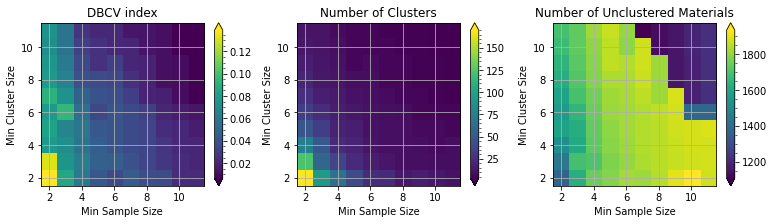

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 3), ncols=3)


# plot just the positive data and save the
# color "mappable" object returned by ax1.imshow
pos = ax1.imshow(DBCV_vals, extent=[1.5,11.5,1.5,11.5])

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
cbar3 = fig.colorbar(pos, ax=ax1, extend='both')

# repeat everything above for the negative data
# you can specify location, anchor and shrink the colorbar
neg = ax2.imshow(N_cluster_vals, extent=[1.5,11.5,1.5,11.5])
cbar2 = fig.colorbar(neg, ax=ax2, extend='both')



# Plot both positive and negative values between +/- 1.2
pos_neg_clipped = ax3.imshow(N_uncluster_vals, extent=[1.5,11.5,1.5,11.5])
# Add minorticks on the colorbar to make it easy to read the
# values off the colorbar.
cbar1 = fig.colorbar(pos_neg_clipped, ax=ax3, extend='both')
cbar1.minorticks_on()
cbar2.minorticks_on()
cbar3.minorticks_on()

ax1.set_xlabel("Min Sample Size")
ax1.set_ylabel("Min Cluster Size")
ax1.grid()
ax1.set_title("DBCV index")

ax2.set_xlabel("Min Sample Size")
ax2.set_ylabel("Min Cluster Size")
ax2.grid()
ax2.set_title("Number of Clusters")

ax3.set_xlabel("Min Sample Size")
ax3.set_ylabel("Min Cluster Size")
ax3.grid()
ax3.set_title("Number of Unclustered Materials")

plt.savefig("2d_hist_hdbscan_params", dpi=100, bbox_inches="tight")
plt.show()
